# Program to read in survey data from XML file and view

## Housekeeping

In [1]:
# Import needed libraries
import os
import re
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Set default directory
os.chdir('<path>')

## Read in Survey Data

In [2]:
"""
Read in input .XML file
Once input file is read in it is split on respondents
and info for each respondent is saved in a different record
Output = resp_split
"""

# Open file
# Survey ID 1
f = open('Survey_Response_Sample_Data_1.xml', 'r')

for line in f:
    resp_split = line.split('<surveyTaker>')           
    # at this point resp_split contains the following:
    # Record 0 contains header type information (that is not needed)
    # Records 1-N contain all info from each of the N-1 respondents  
    # because of the header info, this object contains one more record than
    # the number of respondents
    # therefore number of respondents is calculated here...
num_resp = len(resp_split)-1

# Use first record in resp_split list to get Survey ID and date
survey_info=re.findall('<surveyId>(\d+)\S+<surveyRequestDate>(\S+)</surveyRequestDate>',resp_split[0])
survey_num=survey_info[0][0]
survey_date=datetime.strptime(survey_info[0][1], '%Y-%m-%d')


In [3]:
# View first record (contains "header" information)
resp_split[0]

'<surveyImport xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"><surveyId>1</surveyId><surveyRequestDate>2014-01-14</surveyRequestDate>'

In [4]:
# View first survey respondent record
resp_split[1][:1000]

'<importHeader><respondentId>220</respondentId><segId>25</segId><zipCode>6787</zipCode><nexCd>16</nexCd><Cycle>21</Cycle><fieldDate>2014-01-14</fieldDate></importHeader><demographicInfo><gender>2</gender><age>3</age><hispanic>1</hispanic><race>1</race><groupedHispanicRace>5</groupedHispanicRace><householdIncome>3</householdIncome></demographicInfo><interests><sportsInterest>2</sportsInterest><sports><baseball>1</baseball><basketball>0</basketball><boxingFighting>0</boxingFighting><football>1</football><golf>0</golf><hockey>0</hockey><motorSports>0</motorSports><soccer>0</soccer><tennis>0</tennis><other/></sports><musicInterest>3</musicInterest><music><americana>0</americana><classical>0</classical><christian>0</christian><country>1</country><danceElectronic>1</danceElectronic><jazz>0</jazz><latin>0</latin><pop>0</pop><rapHipHop>0</rapHipHop><rb>0</rb><rock>1</rock><other/></music><moviesInterest>3</moviesInterest><movies><actionAdventure>0</actionAdventure><animation>0</animation><come

## Convert survey data into a Dataframe

In [5]:
# First use resp_split[1] to get list of celeb names and IDs
celeb_name_id = re.findall(r'<name>(\D+)</name><id>(\d+)', resp_split[1])

# Save celeb names and IDs in a dict
celeb_dict={}
for celeb in range(len(celeb_name_id)):
    celeb_dict[int(celeb_name_id[celeb][1])]=celeb_name_id[celeb][0]

In [6]:
# Make list of columns that will be in the DF
df_col_list=['resp_id','gender','age','race_eth','income']
for celeb in celeb_dict.values():
    df_col_list.append(celeb)

In [7]:
# Build DF
survey_df=pd.DataFrame(index=range(num_resp),columns=df_col_list)

In [8]:
# Part 1 of 2 - Respondent demo
for resp in range(1,len(resp_split)):
    resp_info = re.findall(r'<respondentId>(\d+)\S+<gender>(\d+)\S+<age>(\d+)\S+<groupedHispanicRace>(\d+)\S+<householdIncome>(\d+)', resp_split[resp])
    for i in range(5):
        survey_df.iloc[resp-1,i]=resp_info[0][i]

# Part 2 of 2 - Likeability score for each celeb into each celeb's column in DF
    # split respondent data by celeb
    celeb_split = resp_split[resp].split('<name>')
    for celeb in range(1,len(celeb_split)):
        celeb_info = re.findall(r'<id>(\d+)\S+<likeability>(\d)', celeb_split[celeb])
        survey_df.loc[resp-1,celeb_dict[int(celeb_info[0][0])]]=celeb_info[0][1]


In [9]:
# Move ID into Index
survey_df=survey_df.set_index(['resp_id'])

# Convert values to categorical
for column in survey_df.columns:
    survey_df[column]=survey_df[column].astype('category')

survey_df.head()    

,gender,age,race_eth,income,Ben Affleck,Bradley Cooper,Johnny Depp,Leonardo DiCaprio,Scarlett Johansson,Angelina Jolie,...,Kings of Leon,Justin Timberlake,Coldplay,ZZ Ward,Taylor Swift,Justin Bieber,Adam Levine,Jo Nesbo,Miley Cyrus,Howard Stern
resp_id,,,,,,,,,,,,,,,,,,,,,
220,2,3,5,3,4,3,4,4,3,4,...,0,5,4,0,4,2,4,0,3,5
221,2,3,5,1,5,5,4,4,2,2,...,4,3,4,0,2,2,4,0,3,3
223,2,3,5,3,5,3,5,5,0,4,...,3,4,0,0,5,3,5,0,4,5
225,2,3,5,2,4,4,4,5,4,2,...,4,4,4,0,4,1,4,0,3,1
227,1,4,5,4,4,0,4,4,3,4,...,5,3,5,0,4,3,0,0,1,2


# Exloratory Data Analysis

### Example 1 - Counts by score for each celebrity

In [10]:
# Create DF with survey counts by celeb by score
celeb_score_df=survey_df[list(celeb_dict.values())].apply(pd.Series.value_counts)
celeb_score_df

,Ben Affleck,Bradley Cooper,Johnny Depp,Leonardo DiCaprio,Scarlett Johansson,Angelina Jolie,Kim Kardashian,Mila Kunis,Jennifer Lawrence,Brad Pitt,...,Kings of Leon,Justin Timberlake,Coldplay,ZZ Ward,Taylor Swift,Justin Bieber,Adam Levine,Jo Nesbo,Miley Cyrus,Howard Stern
0,66,366,45,39,206,44,70,386,248,35,...,602,55,332,1015,64,53,324,1049,45,73
1,15,5,13,20,8,40,310,7,6,25,...,8,28,19,3,47,367,17,4,275,185
2,34,8,42,56,20,80,312,12,13,55,...,27,74,37,6,92,322,32,4,273,245
3,338,288,292,284,345,319,304,258,335,282,...,301,357,363,99,347,297,371,79,308,345
4,444,311,402,452,363,400,120,296,282,472,...,175,389,272,39,375,98,248,28,186,232
5,299,218,402,345,254,313,80,237,312,327,...,83,293,173,34,271,59,204,32,109,116


In [11]:
# For two celebs
survey_df[['Jennifer Lawrence','Kim Kardashian']].apply(pd.Series.value_counts)

,Jennifer Lawrence,Kim Kardashian
0,248,70
1,6,310
2,13,312
3,335,304
4,282,120
5,312,80


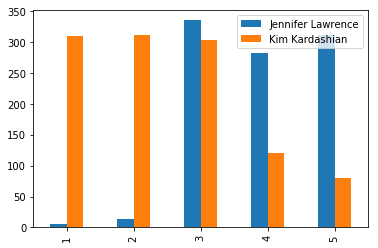

In [31]:
# Adding a bar chart
survey_df[['Jennifer Lawrence','Kim Kardashian']].apply(pd.Series.value_counts).iloc[1:,:].plot(kind='bar')

### Example 2 - Most and Least Popular Celebs

In [15]:
"""
Calculate the average score for each celeb, but without including respondents that gave a zero
Then output top and bottom 10 ranking celebs
"""
# Build a DF where averages will go
celeb_avg_df=pd.DataFrame(index=['Average'],columns=list(celeb_dict.values()))

# Loop across each celeb
for celeb in celeb_dict.values():
    # Initailize values that will be used to calculate the average
    score=0
    count=0
    # Loop down each row in the DF that has counts for each celeb by score
    for row in range(len(celeb_score_df.index)):
        # Multiply the count for that score times the score value
        score=score + (celeb_score_df.loc[row,celeb])*row
        # Test if not in row zero, so that count that will be used to calc the average does not include count of zeros
        if row>0:
            # Update the count value
            count=count + (celeb_score_df.loc[row,celeb])
    # After completion of each loop through the scores (rows) for a celeb, calculate the avg and put it into the destination DF
    celeb_avg_df.loc['Average',celeb]=np.around(score/count,decimals=2)

ranking_df=celeb_avg_df.transpose().sort_values(by='Average', ascending=False)   

In [23]:
print('Highest Ranking Celebs')
ranking_df[:10]

Highest Ranking Celebs


,Average
Johnny Depp,3.99
Jennifer Lawrence,3.93
Mila Kunis,3.92
Leonardo DiCaprio,3.9
Brad Pitt,3.88
Bradley Cooper,3.88
Ben Affleck,3.87
Scarlett Johansson,3.84
Drew Brees,3.83
Angelina Jolie,3.75


In [24]:
print('Lowest Ranking Celebs')
ranking_df[-10:]

Lowest Ranking Celebs


,Average
Tony Romo,3.28
Robin Thicke,3.26
Mark Sanchez,3.2
Lady Gaga,3.12
Howard Stern,2.87
Michael Vick,2.68
Miley Cyrus,2.64
Alex 'A-Rod' Rodriguez,2.61
Kim Kardashian,2.42
Justin Bieber,2.27


### Example 3 - Top Celebs by Age of Survey Respondent

In [38]:
def celeb_age(x):
    """
    Function to calculate average score for each celeb for the age category input
    """
    celeb_age_df=survey_df[survey_df['age']==x][list(celeb_dict.values())].apply(pd.Series.value_counts)
    
    # Build a DF where averages will go
    celeb_avg_age_df=pd.DataFrame(index=['Average'],columns=list(celeb_dict.values()))
    
    # Loop across each celeb
    for celeb in celeb_dict.values():
        # Initailize values that will be used to calculate the average
        score=0
        count=0
        # Loop down each row in the DF that has counts for each celeb by score
        for row in range(len(celeb_age_df.index)):
            # Multiply the count for that score times the score value
            score=score + (celeb_age_df.loc[row,celeb])*row
            # Test if not in row zero, so that count that will be used to calc the average does not include count of zeros
            if row>0:
                # Update the count value
                count=count + (celeb_age_df.loc[row,celeb])
        # After completion of each loop through the scores (rows) for a celeb, calculate the avg and put it into the destination DF
        celeb_avg_age_df.loc['Average',celeb]=np.around(score/count,decimals=2)
        
    return(celeb_avg_age_df.transpose().sort_values(by='Average', ascending=False))

In [46]:
"""
Use function above to build DFs with average scores for each celeb for respondents from two age ranges
"""
# Respondents age 25-34
celeb_avg_age_2_df=celeb_age('2')
# Respondents age 55+
celeb_avg_age_4_df=celeb_age('4')

In [52]:
print('Survey Respondents Age 25-34 Top Ranking Celebs')
celeb_avg_age_2_df.iloc[:10,:]

Survey Respondents Age 25-34 Top Ranking Celebs


,Average
Mila Kunis,4.11
Johnny Depp,4.09
Jennifer Lawrence,4.05
Bradley Cooper,3.97
Leonardo DiCaprio,3.97
Scarlett Johansson,3.94
Justin Timberlake,3.9
Imagine Dragons,3.87
Brad Pitt,3.86
Ben Affleck,3.81


In [53]:
print('Survey Respondents Age 55+ Top Ranking Celebs')
celeb_avg_age_4_df.iloc[:10,:]

Survey Respondents Age 55+ Top Ranking Celebs


,Average
Drew Brees,4.02
Brad Pitt,3.93
Aaron Rodgers,3.92
Ben Affleck,3.89
Johnny Depp,3.88
Leonardo DiCaprio,3.85
Eli Manning,3.84
Angelina Jolie,3.83
Jennifer Lawrence,3.81
Bradley Cooper,3.8


### Example 4 - Compare Two Celebs by Age of Survey Respondent

In [98]:
# Respondents age 25-34
celeb_two_age_2=survey_df[survey_df['age']=='2'][['Justin Timberlake','Aaron Rodgers']].apply(pd.Series.value_counts)
# Respondents age 55+
celeb_two_age_4=survey_df[survey_df['age']=='4'][['Justin Timberlake','Aaron Rodgers']].apply(pd.Series.value_counts)
# Merge the two
celeb_two_age_two=pd.merge(celeb_two_age_2, celeb_two_age_4, left_index=True, right_index=True)
celeb_two_age_two=celeb_two_age_two.rename(columns={'Justin Timberlake_x':'Justin Timberlake 25-34',
                                                    'Aaron Rodgers_x':'Aaron Rodgers 25-34',
                                                    'Justin Timberlake_y':'Justin Timberlake 55+',
                                                    'Aaron Rodgers_y':'Aaron Rodgers 55+'})
celeb_two_age_two

,Justin Timberlake 25-34,Aaron Rodgers 25-34,Justin Timberlake 55+,Aaron Rodgers 55+
0,12,106,21,200
1,12,6,3,0
2,13,8,32,6
3,67,83,175,73
4,107,61,127,92
5,98,45,78,65


<b> Change values in DF to percent of total, excluding respondents that gave a zero value

In [101]:
celeb_two_age_two=celeb_two_age_two.loc[['1','2','3','4','5'],:]
for col in celeb_two_age_two.columns:
    celeb_two_age_two[col]=round(((celeb_two_age_two[col]/celeb_two_age_two[col].sum()))*100,1)
celeb_two_age_two

,Justin Timberlake 25-34,Aaron Rodgers 25-34,Justin Timberlake 55+,Aaron Rodgers 55+
1,4.0,3.0,0.7,0.0
2,4.4,3.9,7.7,2.5
3,22.6,40.9,42.2,30.9
4,36.0,30.0,30.6,39.0
5,33.0,22.2,18.8,27.5


<b> Graph Results

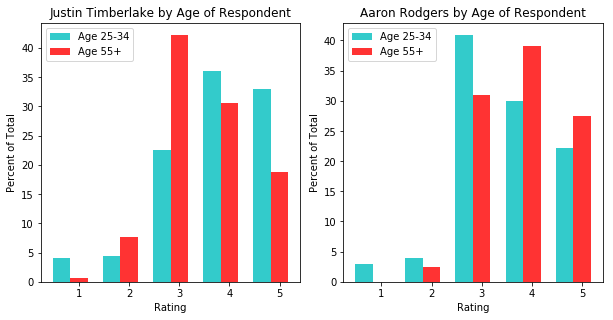

In [170]:
# data to plot
n_groups = len(celeb_two_age_two.index)
 
# create plot 1
#plt.subplot(1,2,1)
plt.axes([0.05, 0.05, 0.60, 0.9])
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, celeb_two_age_two.iloc[:,0], bar_width,
                 alpha=opacity,
                 color='c',
                 label='Age 25-34')
 
rects2 = plt.bar(index + bar_width, celeb_two_age_two.iloc[:,2], bar_width,
                 alpha=opacity,
                 color='r',
                 label='Age 55+')
 
plt.xlabel('Rating')
plt.ylabel('Percent of Total')
plt.title('Justin Timberlake by Age of Respondent')
plt.xticks(index + bar_width, (index+1))
plt.legend(loc='upper left')

# create plot 2
# plt.subplot(1,2,2)
plt.axes([0.75, 0.05, 0.6, 0.9])
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, celeb_two_age_two.iloc[:,1], bar_width,
                 alpha=opacity,
                 color='c',
                 label='Age 25-34')
 
rects2 = plt.bar(index + bar_width, celeb_two_age_two.iloc[:,3], bar_width,
                 alpha=opacity,
                 color='r',
                 label='Age 55+')
 
plt.xlabel('Rating')
plt.ylabel('Percent of Total')
plt.title('Aaron Rodgers by Age of Respondent')
plt.xticks(index + bar_width, (index+1))
plt.legend(loc='upper left')

plt.show()